In [7]:
# Import libaries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os

Download CIFAR 10 dataset from torchvision and create dataloader with batch_size = 256.

In [2]:
from torchvision.transforms.transforms import RandomHorizontalFlip
batch_size = 256
input_size = 32

data_transform = {'train': transforms.Compose([
                 RandomHorizontalFlip(0.5),
                 transforms.RandomCrop(32,4),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                              
]),
'test':transforms.Compose([
                           transforms.Resize(input_size),
                           transforms.CenterCrop(input_size),
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
}
#create training data
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=data_transform['train'])
train_dl = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=2)

#create testing data
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=data_transform['test'])

test_dl = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


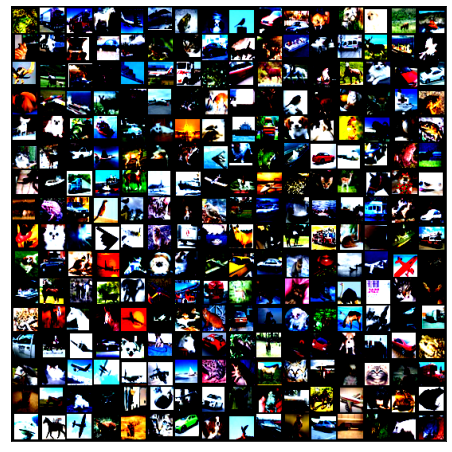

In [3]:
#create viz of batch
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl) 

Create ResNet Structure (https://arxiv.org/abs/1512.03385) from scratch. 

In [4]:
def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size= 3, padding = 1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace = True)]
  
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class Resnet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool = True)
        self.res1 = nn.Sequential(conv_block(128,128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool = True)
        self.conv4 = conv_block(256, 512, pool = True)
        self.res2 = nn.Sequential(conv_block(512,512), conv_block(512, 512))

    #add classification 

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))
    
    #create forward pass to go through all layers
    def forward(self, x):
      out = self.conv1(x)
      out = self.conv2(out)
      out = self.res1(out) + out
      out = self.conv3(out)
      out = self.conv4(out)
      out = self.res2(out) + out
      return self.classifier(out)

Create the training environment to train the ResNet32 (Learning rate=0.1, weight_decay = 1e-4, cross entropy loss function and the SGD optimizer)

In [5]:
#create instence of resnet
net = Resnet(3, 10)

#learning rate
my_lr = 0.1
#weight decay
my_weight_decay = 1e-4
#optimizer
my_optimizer = torch.optim.SGD( net.parameters() , lr=my_lr, weight_decay=my_weight_decay)

#set up gpu
#check for gpu
def get_default_device():
  return torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
  
device = get_default_device()
print(device)  


cuda


Train  for 200 epochs. decay the learning rate by 0.1 at epoch=100 and epoch=150 and save the model for every fifth epoch.

In [9]:

#set number of epoch
EPOCHS = 200

#send network obj to GPU

net.to(device)

#train
for epoch in range(EPOCHS):
  #create criterion
  criterion = nn.CrossEntropyLoss()
  #set to train mode
  net.train()
  
  #create optimizer
  my_lr = 0.1
  optimizer=torch.optim.SGD( net.parameters() , lr=my_lr, weight_decay=1e-4)
  #decay LR on epoch 100 and 150
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma = 0.1)
  losses = []
  running_loss = 0

  #save model on every 5th epoch
  if epoch %5 == 0:
    #Set dir path
    PATH = './training_saves/resnet'

    #check dir exists
    if not os.path.exists(PATH):
      os.makedirs(PATH)

    #create file name
    filename = os.path.join(PATH, 'Model_resnet_checkpoint_' + str(epoch) + '.th')

    #save State
    torch.save(net.state_dict(), filename)

  for i, inp in enumerate(train_dl):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
    
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if epoch%5 == 0 and i ==195:
          ##### NOTE OUTPUT ONLY DISPLAYS ON EVERY 5TH EPOCH... MAY APPEAR STUCK BUT IT WORKS :) ######
            print(f'Training: [Epoch: {epoch}]    [Batch: {i}]    [Loss: {running_loss / 100}]')
            running_loss = 0.0

            
print('Training Done')

Training: [Epoch: 0]    [Batch: 195]    [Loss: 3.548369427919388]
Training: [Epoch: 5]    [Batch: 195]    [Loss: 2.0252289533615113]
Training: [Epoch: 10]    [Batch: 195]    [Loss: 1.2135116577148437]
Training: [Epoch: 15]    [Batch: 195]    [Loss: 0.8326867878437042]
Training: [Epoch: 20]    [Batch: 195]    [Loss: 0.6220937041938305]
Training: [Epoch: 25]    [Batch: 195]    [Loss: 0.4732286614179611]
Training: [Epoch: 30]    [Batch: 195]    [Loss: 0.3694499950110912]
Training: [Epoch: 35]    [Batch: 195]    [Loss: 0.2899816118180752]
Training: [Epoch: 40]    [Batch: 195]    [Loss: 0.2335590909048915]
Training: [Epoch: 45]    [Batch: 195]    [Loss: 0.18681027725338936]
Training: [Epoch: 50]    [Batch: 195]    [Loss: 0.1341063728183508]
Training: [Epoch: 55]    [Batch: 195]    [Loss: 0.12888582093641163]
Training: [Epoch: 60]    [Batch: 195]    [Loss: 0.08590089798904955]
Training: [Epoch: 65]    [Batch: 195]    [Loss: 0.07444378943182528]
Training: [Epoch: 70]    [Batch: 195]    [Loss:

### Training Results:
Training: [Epoch: 0]    [Batch: 195]    [Loss: 3.548369427919388]

Training: [Epoch: 5]    [Batch: 195]    [Loss: 2.0252289533615113]

Training: [Epoch: 10]    [Batch: 195]    [Loss: 1.2135116577148437]

Training: [Epoch: 15]    [Batch: 195]    [Loss: 0.8326867878437042]

Training: [Epoch: 20]    [Batch: 195]    [Loss: 0.6220937041938305]

Training: [Epoch: 25]    [Batch: 195]    [Loss: 0.4732286614179611]

Training: [Epoch: 30]    [Batch: 195]    [Loss: 0.3694499950110912]

Training: [Epoch: 35]    [Batch: 195]    [Loss: 0.2899816118180752]

Training: [Epoch: 40]    [Batch: 195]    [Loss: 0.2335590909048915]

Training: [Epoch: 45]    [Batch: 195]    [Loss: 0.18681027725338936]

Training: [Epoch: 50]    [Batch: 195]    [Loss: 0.1341063728183508]

Training: [Epoch: 55]    [Batch: 195]    [Loss: 0.12888582093641163]

Training: [Epoch: 60]    [Batch: 195]    [Loss: 0.08590089798904955]

Training: [Epoch: 65]    [Batch: 195]    [Loss: 0.07444378943182528]

Training: [Epoch: 70]    [Batch: 195]    [Loss: 0.06595214638393372]

Training: [Epoch: 75]    [Batch: 195]    [Loss: 0.05966629200614989]

Training: [Epoch: 80]    [Batch: 195]    [Loss: 0.057085833940654994]

Training: [Epoch: 85]    [Batch: 195]    [Loss: 0.04797887206077576]

Training: [Epoch: 90]    [Batch: 195]    [Loss: 0.03716268156655133]

Training: [Epoch: 95]    [Batch: 195]    [Loss: 0.03692089101765305]

Training: [Epoch: 100]    [Batch: 195]    [Loss: 0.03864566512638703]

Training: [Epoch: 105]    [Batch: 195]    [Loss: 0.03328760639298707]

Training: [Epoch: 110]    [Batch: 195]    [Loss: 0.02593189226812683]

Training: [Epoch: 115]    [Batch: 195]    [Loss: 0.028264147167501506]

Training: [Epoch: 120]    [Batch: 195]    [Loss: 0.02508622487075627]

Training: [Epoch: 125]    [Batch: 195]    [Loss: 0.023160006297985092]

Training: [Epoch: 130]    [Batch: 195]    [Loss: 0.021108213536208495]

Training: [Epoch: 135]    [Batch: 195]    [Loss: 0.01851355920138303]

Training: [Epoch: 140]    [Batch: 195]    [Loss: 0.01949859867047053]

Training: [Epoch: 145]    [Batch: 195]    [Loss: 0.016637337579741143]

Training: [Epoch: 150]    [Batch: 195]    [Loss: 0.01880402720766142]

Training: [Epoch: 155]    [Batch: 195]    [Loss: 0.015617872055445332]

Training: [Epoch: 160]    [Batch: 195]    [Loss: 0.018332303545321338]

Training: [Epoch: 165]    [Batch: 195]    [Loss: 0.014211294681299478]

Training: [Epoch: 170]    [Batch: 195]    [Loss: 0.013227251949138008]

Training: [Epoch: 175]    [Batch: 195]    [Loss: 0.010712554222263861]

Training: [Epoch: 180]    [Batch: 195]    [Loss: 0.012990634426532779]

Training: [Epoch: 185]    [Batch: 195]    [Loss: 0.014033191693597473]

Training: [Epoch: 190]    [Batch: 195]    [Loss: 0.016427440345287325]

###Training: [Epoch: 195]    [Batch: 195]    [Loss: 0.010539363862480968]

Training takes around 1:20 to run through all 200 epochs.

Epoch with lowest loss was 195.

Test the best model that and calculate the prediction accuracy.

In [40]:

#Best model location - replace checkpoint_XXX with best training epoch
netbackup = net
resnet_PATH = './training_saves/resnet/Model_resnet_checkpoint_195.th'

#load and send to GPU
device = torch.device('cuda')
net = Resnet(3, 10)
net.load_state_dict(torch.load(resnet_PATH))
net.to(device)

correct = 0
total = 0

with torch.no_grad():
    for data in test_dl:
        net.eval()
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'[ResNet - Accuracy on test images: {100*(correct/total)}] \n [Total Correct: {correct}] \n [Total Tested: {total}]')


[ResNet - Accuracy on test images: 90.39] 
 [Total Correct: 9039] 
 [Total Tested: 10000]


### [ResNet - Accuracy on test images: 90.39] 
 
 [Total Correct: 9039] 
 
 [Total Tested: 10000]

VGG16 Model (https://arxiv.org/abs/1409.1556v6) 

In [18]:
#architecture to be passed to layer creation method
#M is for maxpooling
#vgg 16 architecture (16 layers)
VGG16 = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"]


#class to create VGG model arcitecture

class VGG_net(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG16) #calls layer creation function and returns a sequential model (passed list with architecture)
        #create fully connected layers after implemeting relevant VGG architecture
        self.fcl = nn.Sequential(
            nn.Linear(512, 512), 
            nn.ReLU(), 
            nn.Dropout(p=0.5), 
            nn.Linear(512, 512), 
            nn.ReLU(), 
            nn.Dropout(p=0.5), 
            nn.Linear(512, num_classes))


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1) #flatten
        x = self.fcl(x) #pass through fully connected layers
        return x

    def create_conv_layers(self, architecture):
        layers = [] #empty list to hold layers
        in_channels = self.in_channels 

        for x in architecture:
            if type(x) == int:
                #create conv layer
                out_channels = x

                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                kernel_size=(3,3), stride=(1,1), padding=(1,1)), nn.BatchNorm2d(x), nn.ReLU()]
                in_channels = x #create new in_channels for next layer from the out_channels of the previous layer
            
            elif x == "M":
                #create maxpool layer
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers) #unpacks the list and returns a sequential model

  

In [19]:
#create instence of VGG
vgg_net = VGG_net()

#learning rate
my_lr = 0.1
#weight decay
my_weight_decay = 1e-4
#optimizer
my_optimizer = torch.optim.SGD( net.parameters() , lr=my_lr, weight_decay=my_weight_decay)

#set up gpu
#check for gpu
def get_default_device():
  return torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
  
device = get_default_device()
print(device)  

cuda


In [21]:

#set number of epoch
EPOCHS = 200

#send network obj to GPU

vgg_net.to(device)

#train
for epoch in range(EPOCHS):
  #create criterion
  criterion = nn.CrossEntropyLoss()

# set to train mode
  vgg_net.train()

  #create optimizer
  my_lr = 0.1
  optimizer=torch.optim.SGD( vgg_net.parameters() , lr=my_lr, weight_decay=1e-4)
  #decay LR on epoch 100 and 150
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma = 0.1)
  losses = []
  running_loss = 0

  #save model on every 5th epoch
  if epoch %5 == 0:
    #Set dir path
    PATH = './training_saves/VGG'

    #check dir exists
    if not os.path.exists(PATH):
      os.makedirs(PATH)

    #create file name
    filename = os.path.join(PATH, 'Model_vgg_checkpoint_' + str(epoch) + '.th')

    #save State
    torch.save(net.state_dict(), filename)

  for i, inp in enumerate(train_dl):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
    
        outputs = vgg_net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if epoch%5 == 0 and i ==195:
          ##### NOTE OUTPUT ONLY DISPLAYS ON EVERY 5TH EPOCH... MAY APPEAR STUCK BUT IT WORKS :) ######
            print(f'Training: [Epoch: {epoch}]    [Batch: {i}]    [Loss: {running_loss / 100}]')
            running_loss = 0.0


           
print('Training Done')

Training: [Epoch: 0]    [Batch: 195]    [Loss: 1.8967934328317642]
Training: [Epoch: 5]    [Batch: 195]    [Loss: 0.9649438199400902]
Training: [Epoch: 10]    [Batch: 195]    [Loss: 0.6713082157075405]
Training: [Epoch: 15]    [Batch: 195]    [Loss: 0.5082278595864773]
Training: [Epoch: 20]    [Batch: 195]    [Loss: 0.40470356613397596]
Training: [Epoch: 25]    [Batch: 195]    [Loss: 0.3215830381214619]
Training: [Epoch: 30]    [Batch: 195]    [Loss: 0.24994943935424088]
Training: [Epoch: 35]    [Batch: 195]    [Loss: 0.21063322450965644]
Training: [Epoch: 40]    [Batch: 195]    [Loss: 0.17312555775046348]
Training: [Epoch: 45]    [Batch: 195]    [Loss: 0.14315032841637731]
Training: [Epoch: 50]    [Batch: 195]    [Loss: 0.1214579507894814]
Training: [Epoch: 55]    [Batch: 195]    [Loss: 0.10374130215495825]
Training: [Epoch: 60]    [Batch: 195]    [Loss: 0.09965080134570599]
Training: [Epoch: 65]    [Batch: 195]    [Loss: 0.08945066408719868]
Training: [Epoch: 70]    [Batch: 195]    [

### Training Results - VGG

Training: [Epoch: 0]    [Batch: 195]    [Loss: 1.8967934328317642]

Training: [Epoch: 5]    [Batch: 195]    [Loss: 0.9649438199400902]

Training: [Epoch: 10]    [Batch: 195]    [Loss: 0.6713082157075405]

Training: [Epoch: 15]    [Batch: 195]    [Loss: 0.5082278595864773]

Training: [Epoch: 20]    [Batch: 195]    [Loss: 0.40470356613397596]

Training: [Epoch: 25]    [Batch: 195]    [Loss: 0.3215830381214619]

Training: [Epoch: 30]    [Batch: 195]    [Loss: 0.24994943935424088]

Training: [Epoch: 35]    [Batch: 195]    [Loss: 0.21063322450965644]

Training: [Epoch: 40]    [Batch: 195]    [Loss: 0.17312555775046348]

Training: [Epoch: 45]    [Batch: 195]    [Loss: 0.14315032841637731]

Training: [Epoch: 50]    [Batch: 195]    [Loss: 0.1214579507894814]

Training: [Epoch: 55]    [Batch: 195]    [Loss: 0.10374130215495825]

Training: [Epoch: 60]    [Batch: 195]    [Loss: 0.09965080134570599]

Training: [Epoch: 65]    [Batch: 195]    [Loss: 0.08945066408719868]

Training: [Epoch: 70]    [Batch: 195]    [Loss: 0.07587259274441749]

Training: [Epoch: 75]    [Batch: 195]    [Loss: 0.06598055744543671]

Training: [Epoch: 80]    [Batch: 195]    [Loss: 0.05575792846968398]

Training: [Epoch: 85]    [Batch: 195]    [Loss: 0.05539683744776994]

Training: [Epoch: 90]    [Batch: 195]    [Loss: 0.054286658251658085]

Training: [Epoch: 95]    [Batch: 195]    [Loss: 0.04825223343446851]

Training: [Epoch: 100]    [Batch: 195]    [Loss: 0.04501355183077976]

Training: [Epoch: 105]    [Batch: 195]    [Loss: 0.04136227624840103]

Training: [Epoch: 110]    [Batch: 195]    [Loss: 0.03766489110770635]

Training: [Epoch: 115]    [Batch: 195]    [Loss: 0.038471878838608975]

Training: [Epoch: 120]    [Batch: 195]    [Loss: 0.03830855802167207]

Training: [Epoch: 125]    [Batch: 195]    [Loss: 0.033801892527844754]

Training: [Epoch: 130]    [Batch: 195]    [Loss: 0.03607370598590933]

Training: [Epoch: 135]    [Batch: 195]    [Loss: 0.03341698741656728]

Training: [Epoch: 140]    [Batch: 195]    [Loss: 0.029396960153244434]

Training: [Epoch: 145]    [Batch: 195]    [Loss: 0.03240490853029769]

Training: [Epoch: 150]    [Batch: 195]    [Loss: 0.02983944357431028]

Training: [Epoch: 155]    [Batch: 195]    [Loss: 0.02632739361084532]

Training: [Epoch: 160]    [Batch: 195]    [Loss: 0.02979554618068505]

Training: [Epoch: 165]    [Batch: 195]    [Loss: 0.03683320201933384]

Training: [Epoch: 170]    [Batch: 195]    [Loss: 0.026719553321891]

Training: [Epoch: 175]    [Batch: 195]    [Loss: 0.025937152411206626]

Training: [Epoch: 180]    [Batch: 195]    [Loss: 0.028489215970621443]

Training: [Epoch: 185]    [Batch: 195]    [Loss: 0.024169510611100124]

Training: [Epoch: 190]    [Batch: 195]    [Loss: 0.028449522543814963]

### Training: [Epoch: 195]    [Batch: 195]    [Loss: 0.017525473960558882]

Training takes around 1:15 to run through all 200 epochs.

Epoch with lowest loss was epoch 195


In [39]:
#no need to load saved file as last iteration produced the lowest loss. Call same model directly for testing
with torch.no_grad():
    for data in test_dl:
        vgg_net.eval()
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = vgg_net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'[VGG - Accuracy on test images: {100*(correct/total)}] \n [Total Correct: {correct}] \n [Total Tested: {total}]')

[VGG - Accuracy on test images: 90.42999999999999] 
 [Total Correct: 27129] 
 [Total Tested: 30000]


###[VGG - Accuracy on test images: 90.43]

 [Total Correct: 27129] 

 [Total Tested: 30000]